# Step 2: Training Faster-RCNN using Detectron2 Framework

> @author Zhu, Wenzhen (wenzhu@amazon.com)

> @date   12/21/2022


If the following cell returns `ModuleNotFoundError: No module named 'detectron2'` Then go back to step00 and do the environment setup.

And make sure the kernel you are using is `conda_pytorch_p36`

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Register the **Castings** dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).

Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format.

## 1. Register the dataset

In [2]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version

1.8.0+cu101 True


In [3]:
# if your dataset is in COCO format, 
# this cell can be replaced by the following three lines:
sm_root = "/home/ec2-user/SageMaker/"
train_annotation = sm_root + "saman-team/annotations/train.json"
test_annotation = sm_root + "saman-team/annotations/test.json"

# the image has been copied to desired destination 
# in the step 01 notebook
train_img_dir = sm_root + "saman-team/train"
test_img_dir = sm_root + "saman-team/test"

from detectron2.data.datasets import register_coco_instances

register_coco_instances(
    "casting_train", 
    {}, 
    train_annotation, 
    train_img_dir)

register_coco_instances(
    "casting_test",
    {}, 
    test_annotation, 
    test_img_dir)

In [4]:
castings_metadata = MetadataCatalog.get("casting_test")

In [5]:
castings_metadata

namespace(name='casting_test',
          json_file='/home/ec2-user/SageMaker/saman-team/annotations/test.json',
          image_root='/home/ec2-user/SageMaker/saman-team/test',
          evaluator_type='coco')

In [6]:
train_data = DatasetCatalog.get("casting_train")
data_sample = DatasetCatalog.get("casting_test")

WARNING [01/06 23:50:08 d2.data.datasets.coco]: /home/ec2-user/SageMaker/saman-team/annotations/train.json contains 2367 annotations, but only 2365 of them match to images in the file.
[01/06 23:50:08 d2.data.datasets.coco]: Loaded 685 images in COCO format from /home/ec2-user/SageMaker/saman-team/annotations/train.json
WARNING [01/06 23:50:08 d2.data.datasets.coco]: /home/ec2-user/SageMaker/saman-team/annotations/test.json contains 502 annotations, but only 499 of them match to images in the file.
[01/06 23:50:08 d2.data.datasets.coco]: Loaded 171 images in COCO format from /home/ec2-user/SageMaker/saman-team/annotations/test.json


In [10]:
data_sample

[{'file_name': '/home/ec2-user/SageMaker/saman-team/test/C0001_0007.png',
  'height': 572,
  'width': 768,
  'image_id': 0,
  'annotations': []},
 {'file_name': '/home/ec2-user/SageMaker/saman-team/test/C0001_0008.png',
  'height': 572,
  'width': 768,
  'image_id': 1,
  'annotations': [{'bbox': [496.0, 477.0, 22.0, 26.0],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [493.0, 255.0, 24.0, 24.0],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [4.0, 215.0, 15.0, 15.0],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]},
 {'file_name': '/home/ec2-user/SageMaker/saman-team/test/C0001_0014.png',
  'height': 572,
  'width': 768,
  'image_id': 2,
  'annotations': [{'bbox': [485.0, 522.0, 23.0, 23.0],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [502.0, 303.0, 20.0, 22.0],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'bbox': [19.0, 225.0, 18.0, 16.0],
    'category_id': 0,


In [7]:
def plot_groundtruth(n, size=15, output_prefix='./visualization_output/groundtruth/'):
    # Pick from validataion set for it's smaller so faster
    newspaper_metadata = MetadataCatalog.get("casting_test")
    data_sample = DatasetCatalog.get("casting_test")
    
    for d in random.sample(data_sample, n):
        print(d["file_name"])
        img = cv2.imread(d["file_name"])
#         print(img)
        visualizer = Visualizer(
            img[:, :, ::-1], 
            metadata=newspaper_metadata, 
            scale=0.5)
        out = visualizer.draw_dataset_dict(d)
        plt.figure(figsize=(size,size))
        out_img = out.get_image()[:, :, ::-1]
        plt.imshow(out_img)
        fname = d["file_name"].split('/')[-1].split('.')[0]
        os.makedirs(output_prefix, exist_ok=True)
        fpath = output_prefix + fname + '.png'
        plt.imsave(fpath, out_img)

In [8]:
d = random.sample(data_sample, 1)[0]
img = cv2.imread(d["file_name"])

WARNING [01/06 23:50:15 d2.data.datasets.coco]: /home/ec2-user/SageMaker/saman-team/annotations/test.json contains 502 annotations, but only 499 of them match to images in the file.
[01/06 23:50:15 d2.data.datasets.coco]: Loaded 171 images in COCO format from /home/ec2-user/SageMaker/saman-team/annotations/test.json
/home/ec2-user/SageMaker/saman-team/test/C0042_0030.png
/home/ec2-user/SageMaker/saman-team/test/C0007_0013.png
/home/ec2-user/SageMaker/saman-team/test/C0045_0019.png
/home/ec2-user/SageMaker/saman-team/test/C0062_0007.png
/home/ec2-user/SageMaker/saman-team/test/C0034_0015.png


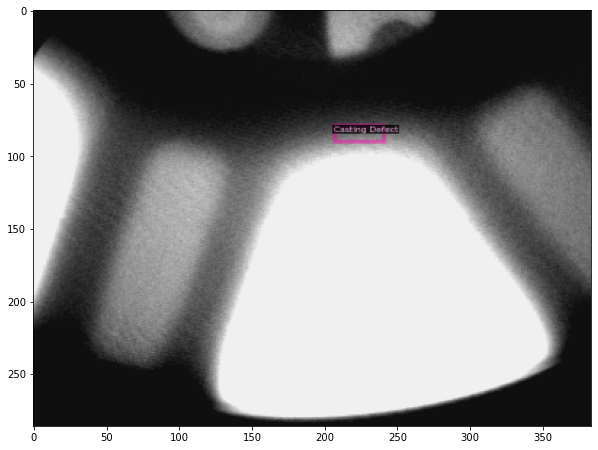

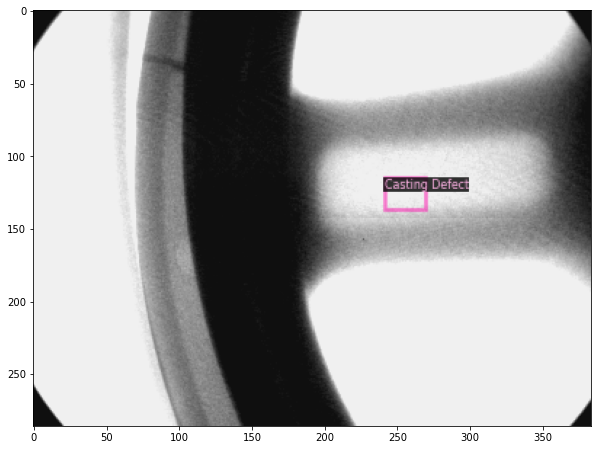

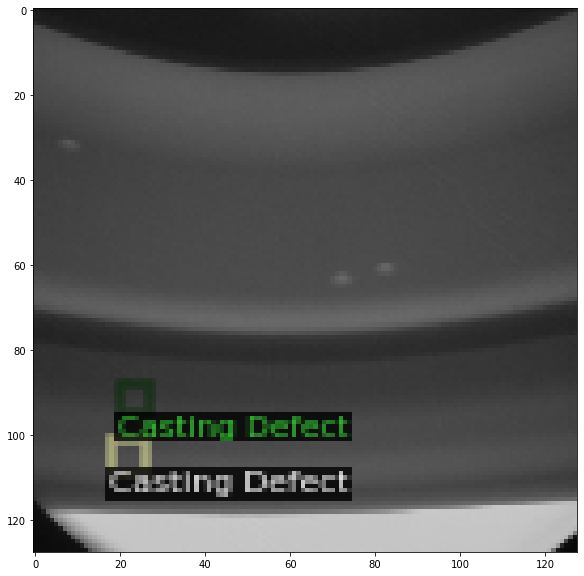

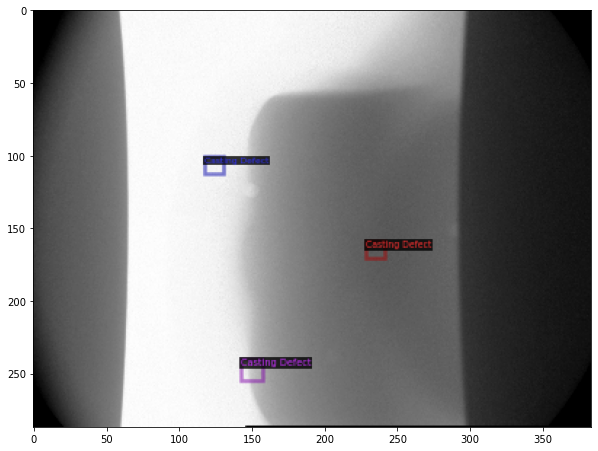

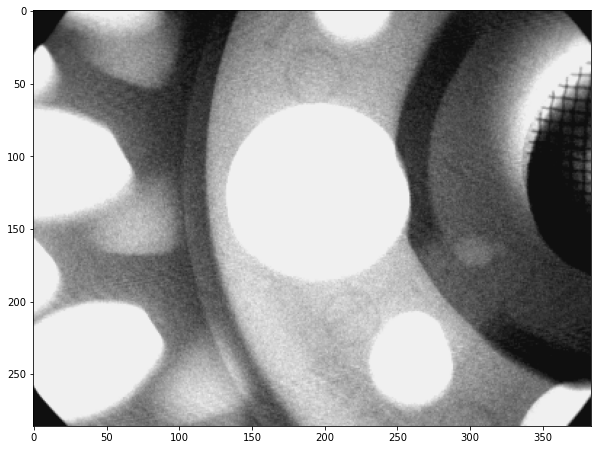

In [9]:
plot_groundtruth(5, size=10)

## Train Mask R-CNN (R50-FPN-3x)

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.

In [9]:
train_metadata = MetadataCatalog.get("casting_train")

In [10]:
train_metadata

namespace(name='casting_train',
          json_file='/home/ec2-user/SageMaker/saman-team/annotations/train.json',
          image_root='/home/ec2-user/SageMaker/saman-team/train',
          evaluator_type='coco',
          thing_classes=['Casting Defect'],
          thing_dataset_id_to_contiguous_id={1: 0})

### Test train 20 epochs

The code currently train for around 12 epochs of COCO with default values.
The reason is that the number of iterations also take into account the batch size and the number of GPUs.

In [ ]:
from detectron2.engine import DefaultTrainer



# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file(
#     "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
# )
# cfg.DATASETS.TRAIN = ("newspaper_train",)
# cfg.DATASETS.TEST = ("newspaper_test",)
# cfg.DATALOADER.NUM_WORKERS = 4 # num_workers attribute tells the data loader instance how many sub-processes to use for data loading
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo

# cfg.SOLVER.IMS_PER_BATCH = 4      #  mini-batch size of 1 image per GPU
# cfg.SOLVER.BASE_LR = 3e-4         # pick a good LR
# cfg.SOLVER.MAX_ITER = 255000      # 2,500 images * 20 = 50,000
# cfg.SOLVER.STEPS = []             # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7              # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

# cfg.OUTPUT_DIR = "./output_mask_rcnn_NewspaperNet"

In [ ]:
! cd /home/ec2-user/SageMaker/detectron2/tools/ && python train_net.py \
--config-file ../configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml \
--num-gpus 4 \

In [ ]:
from detectron2.engine import launch

def wenzhen_train():
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    return trainer.train()

launch(
    wenzhen_train,
    4,
    num_machines=0,
)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=Flse)
trainer.train()

# Results Visuals

In [ ]:
def plot_test(model, n, size=30, folder=None):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
    cfg.DATASETS.TEST = ("ancestry_ds1_test", )
    predictor = DefaultPredictor(cfg)

    test = DatasetCatalog.get("ancestry_ds1_test")
    test_metadata = MetadataCatalog.get("ancestry_ds1_test")

    for d in random.sample(test, n):
        
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(
            img[:, :, ::-1], 
            metadata=test_metadata, 
            scale=0.5)
        # out = visualizer.draw_dataset_dict(d)
        outputs = predictor(img)
        v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize=(size, size))
        out_img = v.get_image()[:, :, ::-1]
        plt.imshow(out_img)
        fname = d["file_name"].split('/')[-1].split('.')[0]
        if not folder:
            fpath = './vis_output/test/' + fname + '.png'
        else:
            fpath = f'./vis_output/{folder}/' + fname + '.png'
        plt.imsave(fpath, out_img)

In [ ]:
def plot_test_vs_gt(model, n, size=30):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
    cfg.DATASETS.TEST = ("ancestry_ds1_test", )
    predictor = DefaultPredictor(cfg)

    test = DatasetCatalog.get("ancestry_ds1_test")
    test_metadata = MetadataCatalog.get("ancestry_ds1_test")

    for d in random.sample(test, n):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(
            img[:, :, ::-1], 
            metadata=test_metadata, 
            scale=0.5)
        # out = visualizer.draw_dataset_dict(d)
        outputs = predictor(img)
        v_pred = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
        img_pred = v_pred.get_image()[:, :, ::-1]
        
        v_gt = visualizer.draw_dataset_dict(d)
        img_gt = v_gt.get_image()[:, :, ::-1]
        
        
    
        fig, ax = plt.subplots(1,2, figsize=(size, size))
        ax[0].imshow(img_pred)
        ax[1].imshow(img_gt)
        fname = d["file_name"].split('/')[-1].split('.')[0]
        fpath = './vis_output/compare/' + fname + '.png'
#         fig.savefig(fpath)

In [ ]:
plot_test_vs_gt("model_0059999.pth",  n=4, size=10)

## Visualization - Result Train only 300 iterations - about 2 minutes

In [ ]:
plot_test("model_iter_300_lr_002_batchsize_128.pth", n=4, size=40, folder="test_model_iter_300_lr_002_batchsize_128")

In [ ]:
test = DatasetCatalog.get("ancestry_ds1_test")
test_metadata = MetadataCatalog.get("ancestry_ds1_test")

for d in random.sample(test, 6):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1], 
        metadata=test_metadata, 
        scale=0.5)
    # out = visualizer.draw_dataset_dict(d)
    outputs = predictor(img)
    v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(30,30))
    plt.imshow(v.get_image()[:, :, ::-1])

## Train Fast RCNN (R50-FPN)
Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.

In [ ]:
cfg

In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml")
)

cfg.DATASETS.TRAIN = ("ancestry_ds1_train")
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  

In [ ]:
from detectron2.engine import launch
def wenzhen_train():
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    return trainer.train()

launch(
    wenzhen_train,
    num_gpus_per_machine=4
)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)

In [ ]:
build_detection_train_loader(cfg)

In [ ]:
print(cfg.DATASETS.TRAIN)
filter_empty=cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS
print(filter_empty)
if cfg.MODEL.LOAD_PROPOSALS:
    proposal_files=cfg.DATASETS.PROPOSAL_FILES_TRAIN
    print(proposal_files)
else:
    None

In [ ]:
dataset_dicts = [DatasetCatalog.get(dataset_name) for dataset_name in ['ancestry_ds1_train']]

In [ ]:
dataset_dicts

In [ ]:
proposal_files = ('detectron2://COCO-Detection/rpn_R_50_FPN_1x/137258492/coco_2017_train_box_proposals_21bc3a.pkl',)

In [ ]:
ds_dicts = [ 
    load_proposals_into_dataset(dataset_i_dicts, proposal_file) 
    for dataset_i_dicts, proposal_file in zip(dataset_dicts, proposal_files)
]

In [ ]:
import itertools
import logging
import numpy as np
import operator
import pickle
import torch.utils.data
from tabulate import tabulate
from termcolor import colored

from detectron2.config import configurable
from detectron2.structures import BoxMode
from detectron2.utils.comm import get_world_size
from detectron2.utils.env import seed_all_rng
from detectron2.utils.file_io import PathManager

def load_proposals_into_dataset(dataset_dicts, proposal_file):
    """
    Load precomputed object proposals into the dataset.

    The proposal file should be a pickled dict with the following keys:

    - "ids": list[int] or list[str], the image ids
    - "boxes": list[np.ndarray], each is an Nx4 array of boxes corresponding to the image id
    - "objectness_logits": list[np.ndarray], each is an N sized array of objectness scores
      corresponding to the boxes.
    - "bbox_mode": the BoxMode of the boxes array. Defaults to ``BoxMode.XYXY_ABS``.

    Args:
        dataset_dicts (list[dict]): annotations in Detectron2 Dataset format.
        proposal_file (str): file path of pre-computed proposals, in pkl format.

    Returns:
        list[dict]: the same format as dataset_dicts, but added proposal field.
    """
    logger = logging.getLogger(__name__)
    logger.info("Loading proposals from: {}".format(proposal_file))

    with PathManager.open(proposal_file, "rb") as f:
        proposals = pickle.load(f, encoding="latin1")

    # Rename the key names in D1 proposal files
    rename_keys = {"indexes": "ids", "scores": "objectness_logits"}
    for key in rename_keys:
        if key in proposals:
            proposals[rename_keys[key]] = proposals.pop(key)

    # Fetch the indexes of all proposals that are in the dataset
    # Convert image_id to str since they could be int.
    cnt = 0
    for record in dataset_dicts:
        cnt += 1
        if cnt < 5:
            print(record)
            print(record["image_id"])
        
    img_ids = set({str(record["image_id"]) for record in dataset_dicts})
    id_to_index = {str(id): i for i, id in enumerate(proposals["ids"]) if str(id) in img_ids}
    print(id_to_index)

    # Assuming default bbox_mode of precomputed proposals are 'XYXY_ABS'
    bbox_mode = BoxMode(proposals["bbox_mode"]) if "bbox_mode" in proposals else BoxMode.XYXY_ABS

    for record in dataset_dicts:
        # Get the index of the proposal
        i = id_to_index[str(record["image_id"])]

        boxes = proposals["boxes"][i]
        objectness_logits = proposals["objectness_logits"][i]
        # Sort the proposals in descending order of the scores
        inds = objectness_logits.argsort()[::-1]
        record["proposal_boxes"] = boxes[inds]
        record["proposal_objectness_logits"] = objectness_logits[inds]
        record["proposal_bbox_mode"] = bbox_mode

    return dataset_dicts

In [ ]:
from  detectron2.data import get_detection_dataset_dicts
get_detection_dataset_dicts("ancestry_ds1_train", filter_empty=True, min_keypoints=0, proposal_files=None)

In [ ]:
dataset_dicts2 = DatasetCatalog.get("ancestry_ds1_train")

In [ ]:
dataset_dicts

In [ ]:
cnt = 0
for record in dataset_dicts:
    cnt+=1
    if cnt < 5:
        print(record["image_id"])

In [ ]:
load_proposals_into_dataset(dataset_dicts, "detectron2://COCO-Detection/rpn_R_50_FPN_1x/137258492/coco_2017_train_box_proposals_21bc3a.pkl")

In [ ]:
dataset_dicts[:3]

In [ ]:
load_proposals_into_dataset(dataset_dicts2, "detectron2://COCO-Detection/rpn_R_50_FPN_1x/137258492/coco_2017_train_box_proposals_21bc3a.pkl")

In [ ]:
proposal_file = "detectron2://COCO-Detection/rpn_R_50_FPN_1x/137258492/coco_2017_train_box_proposals_21bc3a.pkl"
with PathManager.open(proposal_file, "rb") as f:
    proposals = pickle.load(f, encoding="latin1")

In [ ]:
proposals.keys()

In [ ]:
proposals['ids']